In [1]:

import numpy as np
import datetime as dt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error,root_mean_squared_error,mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import sklearn
import matplotlib.pyplot as plt
import customFunctions as fct

scaler=StandardScaler()

In [2]:
# Read in the data using the simple reading and cleaning function
data_ERA5 = fct.read_ts_csv(f'reanalysis.csv')
data_LIDAR = fct.read_ts_csv(f'measurements/lidar.csv')

# Resample the data to 1h intervals
data_ERA5 = data_ERA5.resample('h', on='Time').mean()
data_LIDAR = data_LIDAR.resample('h', on='Time').mean()

# create a merged dataframe containing the ERA5 and the LIDAR data
data_mrgd = pd.merge(data_LIDAR, data_ERA5, how='right', on='Time')

# Ensure that the datetime format is used for the datetime index
data_mrgd.index = pd.to_datetime(data_mrgd.index)

data_mrgd['Mon']      = data_mrgd.index.strftime('%m')
data_mrgd['Hour']     = data_mrgd.index.strftime('%H')
data_mrgd.tail()

,WS-99.2,WD-99.2,WS100,WD100,Mon,Hour
Time,,,,,,
2024-12-31 19:00:00,NaN,NaN,21.859,225.5,12,19
2024-12-31 20:00:00,NaN,NaN,21.991,226.8,12,20
2024-12-31 21:00:00,NaN,NaN,22.290,228.4,12,21
2024-12-31 22:00:00,NaN,NaN,21.714,228.1,12,22
2024-12-31 23:00:00,NaN,NaN,22.628,227.7,12,23


In [3]:
# choose a value for comparability
RSEED = 42

# define how many percent of data should be excluded from training to use it for testing
test_size = 0.3

# set variables 
# model data = Features 
X = pd.DataFrame(data_mrgd[['WS100','WD100','Mon','Hour']])

# valid values = observations
Y = pd.DataFrame(data_mrgd['WS-99.2'].copy())

# remove nan values
# find index of nan values
idx = Y[Y.isnull().any(axis=1)].index

#find index of valid values
valid_values = Y[Y.notnull().all(axis=1)].index
valid_values = [data_mrgd.index.get_loc(value) for value in valid_values]

XtoPredict = X.loc[idx]

# features
x = X.iloc[valid_values]

# target
y = Y.iloc[valid_values]
xcols = X.columns

In [4]:
# split data into training and test data (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=RSEED)

# scale data to a common basis (e.g. WS ranges from 0-30 m/s while wind direction from 0 to 360, scaling fits them into a common range)
# scaling is done based on trainings data (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
X_train_scaled = scaler.fit_transform(X_train)

# scaling procedure is transfered to test data
X_test_scaled = scaler.transform(X_test)  

In [16]:
# Preparation
# set hyperparameters for ML-model
import sklearn.gaussian_process
import sklearn.neighbors
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared


param_grid_RadiusNeighborsRegressor = {
              "radius"            : np.arange(0.1, 1, .1),
              "leaf_size"         : np.arange(1, 10, 1),
              "p"                 : [1],
              "weights"           : ['uniform', 'distance'],
              "metric"            : ['euclidean','manhattan','minkowski'] 
             }

param_grid_KNeighbors = {
              "n_neighbors"       : [2,5,12,30],
              "leaf_size"         : [1, 2, 3,15,30],
              "p"                 : [1,2],
              "weights"           : ['uniform', 'distance'],
              "metric"            : ['euclidean','manhattan','minkowski'] 
             }

param_grid_LinReg = {
            "fit_intercept"     : [False, True],
            "copy_X"            : [False, True]
}

# Define kernels:
ker_rbf = ConstantKernel(1.0, constant_value_bounds="fixed") * RBF(1.0, length_scale_bounds="fixed")

# ker_rq = ConstantKernel(1.0, constant_value_bounds="fixed") * RationalQuadratic(alpha=0.1, length_scale=1)

# ker_expsine = ConstantKernel(1.0, constant_value_bounds="fixed") * ExpSineSquared(1.0, 5.0, periodicity_bounds=(1e-2, 1e1))

kernel_list = [ker_rbf]

param_grid_Gaussian = {
            "kernel"    : kernel_list, # ['ExpSineSquared', 'ConstantKernel', 'WhiteKernel']
            "alpha"     : np.arange(4, 5, 0.1) * 10 ** -10,
            "optimizer" : ['fmin_l_bfgs_b']
}

# chose which ML model to use (e.g. linear regression, random Forest, Decision tree, AdaBoost, XGBoost, Ridge regression, )
# check sklearn + model for correct naming and more information)
# consider to import the packages before

# classifier = sklearn.linear_model.LinearRegression()
# classifier = KNeighborsRegressor()
# Randomforest, 
classifier = sklearn.neighbors.RadiusNeighborsRegressor()
# classifier = sklearn.gaussian_process.GaussianProcessRegressor()

# how many times shall the cross validation be done
n          = 5

# according to which metrics shall the performance be tested
scoring    = 'neg_mean_squared_error'

# train the model
# GridSearch finds the best parameter combination for the model for which the score is minimal. 
# A cross validation is done to compare results from different subsets, 
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
grid_model = GridSearchCV(classifier, param_grid=param_grid_RadiusNeighborsRegressor, cv=n, scoring=scoring,\
                                  verbose=0, n_jobs=-1).fit(X_train_scaled, y_train)

best_model = grid_model.best_estimator_
print('Best score:\n{:.2f}'.format(grid_model.best_score_))
print("Best parameters:\n{}".format(grid_model.best_params_))

# make predictions using the trainings to check model performance
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
y_train_cv      = cross_val_predict(best_model, X_train_scaled, y_train, cv=n+2)

# predict values using trained model and test data (features)
y_test_predicted = best_model.predict(X_test_scaled)

# make your final prediction for the entire (long-term) period
X_scaledN = scaler.transform(X)
predictions = best_model.predict(X_scaledN)

# Come up with a Metric to compare the correction classifiers MBE, EMD, ...

c:\Users\jan\Documents\GitHub\Project_Python_Programming_in_Energy_Science\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [        nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan -1.78184028 -1.61417
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan


Best score:
-1.61
Best parameters:
{'leaf_size': np.int64(1), 'metric': 'euclidean', 'p': 1, 'radius': np.float64(0.9), 'weights': 'distance'}


c:\Users\jan\Documents\GitHub\Project_Python_Programming_in_Energy_Science\.venv\Lib\site-packages\sklearn\neighbors\_regression.py:508: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


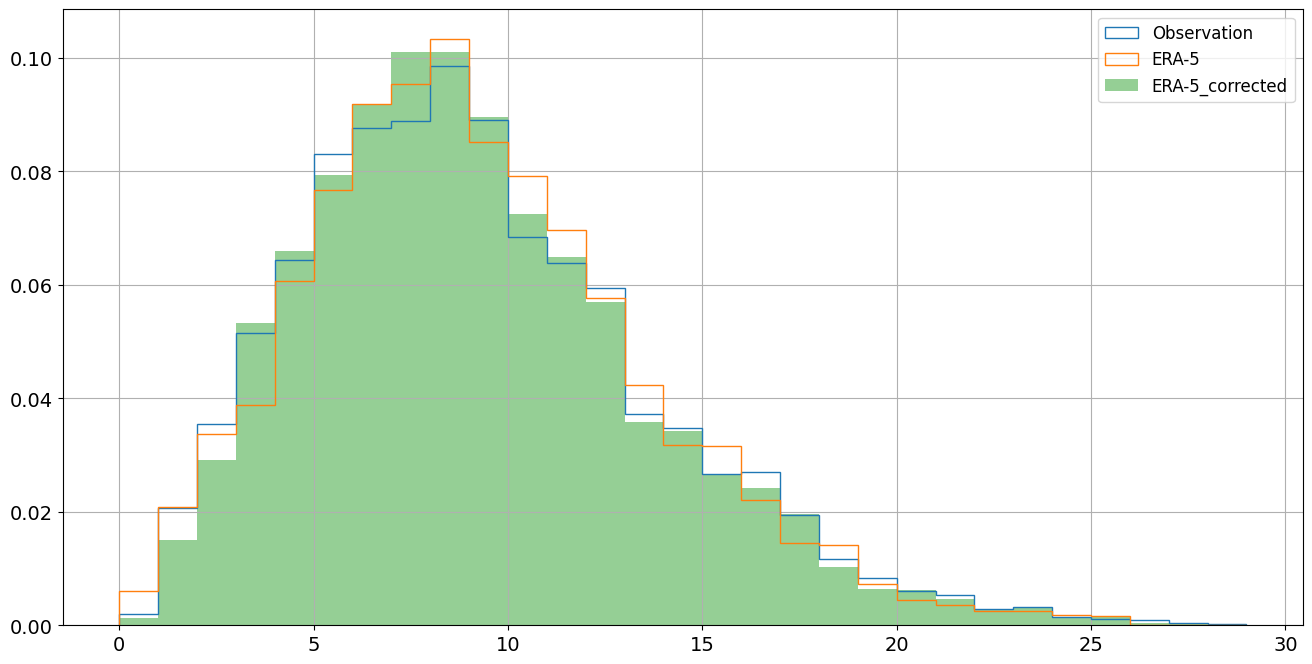

In [17]:
nbins = np.arange(0, 30, 1)

fig = plt.figure(figsize=(16,8))
plt.hist(data_mrgd['WS-99.2'].iloc[valid_values], nbins, label='Observation', histtype='step', density=True)
plt.hist(data_mrgd['WS100'].iloc[valid_values], nbins, label='ERA-5', histtype='step', density=True)
plt.hist(predictions[valid_values], nbins, label='ERA-5_corrected', alpha=0.5, density=True)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend(fontsize= 12)
plt.grid()